In [1]:
import li.analysis as la
import li.EvaluationHelpers as eh

import os
import numpy as np
import pandas as pd
import scipy.constants as const
import matplotlib.pyplot as plt

# Data Loading and Definition of Variables

In [2]:
# path to images
# images_set = "D-TOF_imaging_750"
# date = "20250303"

images_set = "D-effMass_810G_Bragg"
date = "20250304"

path_dir = "Z:/Archiv/2D/Experiment/2025/" + date + "/Images" + date + "/" + images_set + "/"
path_file = os.listdir(path_dir)

print(len(path_file))

7485


In [3]:
# grab loop variable names
variables = la.loop_variables(path_dir + path_file[0])[1]
var_vals = la.loop_variables(path_dir + path_file[0])[0]

In [4]:
for i, var in enumerate(variables):
    print(f"{var}: {var_vals[i][0]} - {var_vals[i][-1]}")

i: 1.0 - 10.0
Vcrit_Lattice_Constant: 0.7 - 0.95
Vcrit_Freq_Diff_kHz: 14.0 - 26.0


In [5]:
# experiment variables loaded from experiment control
info = la.GetImageMetadata(path_dir + path_file[-1])
info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))
# info_sorted

# Image Processing

In [6]:
%%time
# create initial dictionary with all raw images
images_raw = eh.createImageInfoList([path_dir], variables)

CPU times: total: 172 ms
Wall time: 1.12 s


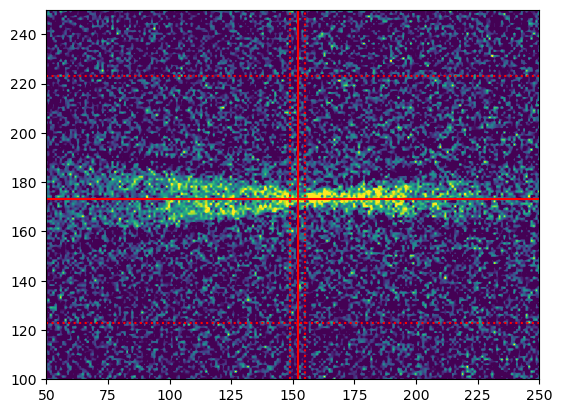

In [7]:
# determine optimal ROI
center = (173, 152)
h = 50
w = 3

single_prc = la.density_builder([images_raw[3]], variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = True)

plt.imshow(single_prc.iloc[0]["density"].data, vmin = 0, vmax = 3, cmap = "viridis")

plt.xlim(50, 250)
plt.ylim(100, 250)


plt.axhline(center[0], c = "red")
plt.axhline(center[0] - h, c = "red", ls = ":")
plt.axhline(center[0] + h, c = "red", ls = ":")

plt.axvline(center[1], c = "red")
plt.axvline(center[1] - w, c = "red", ls = ":")
plt.axvline(center[1] + w, c = "red", ls = ":")


plt.show()

In [8]:
%%time
# calculate all density images and apply mask
images_prc = la.density_builder(images_raw, variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)

|████████████████████████████████████████| 1497/1497 [100%] in 5:49.3 (4.29/s)  
CPU times: total: 2min 40s
Wall time: 5min 49s


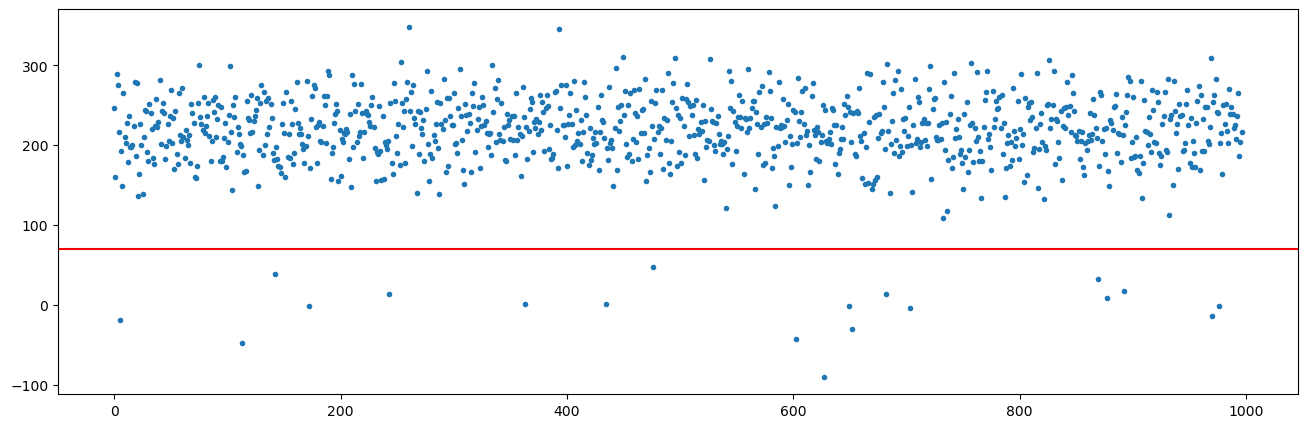

In [9]:
# filter out missed shots
bol = []

for rate in var_vals[1]:

    for i, im in images_prc[images_prc["Vcrit_Lattice_Constant"] == rate].iterrows():
        bol.append(np.sum(im["density"].compressed()))

plt.figure(figsize = (16, 5))

plt.plot(bol, ".")
plt.axhline(70, c = "r")

plt.ylim(None, None)

plt.show()

In [10]:
%%time
# filter missed shots
images_fil = la.filter(images_prc, 70)

dropped 30
dropped 131
dropped 133
dropped 613
dropped 637
dropped 652
dropped 721
dropped 791
dropped 802
dropped 854
dropped 869
dropped 946
dropped 949
dropped 952
dropped 990
dropped 1026
dropped 1057
dropped 1107
dropped 1125
dropped 1135
dropped 1253
dropped 1288
dropped 1320
dropped 1349
dropped 1390
dropped 1451
CPU times: total: 484 ms
Wall time: 541 ms


In [11]:
# plt.imshow((images_fil.iloc[0]["density"] +
#             images_fil.iloc[1]["density"] +
#             images_fil.iloc[2]["density"] +
#             images_fil.iloc[3]["density"] +
#             images_fil.iloc[4]["density"] +
#             images_fil.iloc[5]["density"] +
#             images_fil.iloc[6]["density"] +
#             images_fil.iloc[7]["density"])/8, vmin = 0, vmax = 3, cmap = "viridis")
#
# plt.xlim(125, 175)
# plt.ylim(100, 250)
#
# plt.show()

In [12]:
# plt.imshow(images_fil["density"].mean(numeric_only = False), vmin = 0, vmax = 3, cmap = "viridis")
#
# plt.xlim(125, 175)
# plt.ylim(100, 250)
#
# plt.show()

In [13]:
%%time
# group by loop variables and average over iterations
images_grp = la.group(images_fil, variables, "i", info_sorted["Csat"], info_sorted["Img_Illumination_Time"])

MULTI MODE
CPU times: total: 1min 6s
Wall time: 1min 26s


In [14]:
%%time
# make T4 fits 
images_fit = la.T4_fit(images_grp)

CPU times: total: 2.3 s
Wall time: 5.03 s


In [15]:
%%time
# calculate response
images_res = la.response(images_fit, variables[2], var_vals[2][0])

CPU times: total: 0 ns
Wall time: 7.84 ms


# Visualization

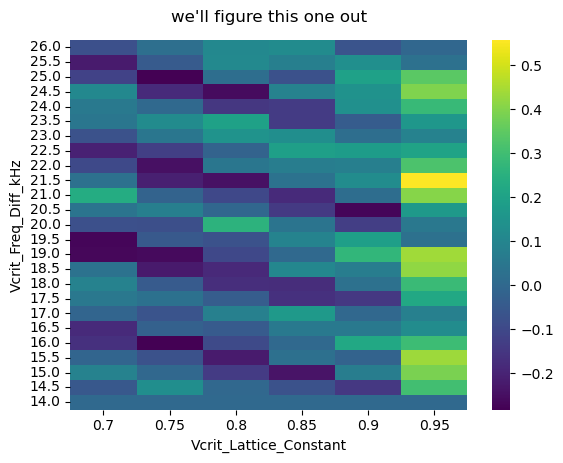

In [17]:
la.visualize(images_res, variables[2], variables[1], "response", "we'll figure this one out", vmin = None, vmax = None, cmap = "viridis")

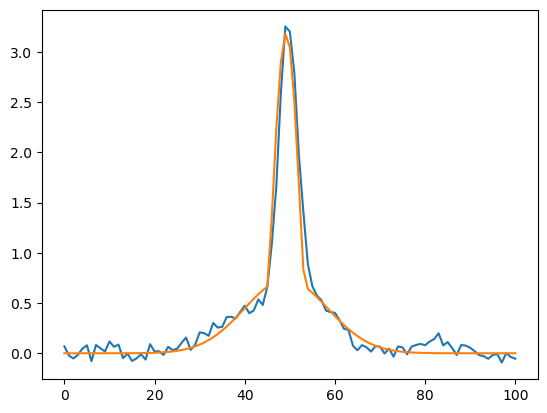

[4.492483960170973, 0.4224871793351772]


In [21]:
field = 0

T4 = np.mean(images_fit["density"].iloc[field], axis = 1).compressed()
pos = np.arange(0, len(T4))

plt.plot(pos, T4)

plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), images_fit["T4_params"].iloc[field][0],
                                                          images_fit["T4_params"].iloc[field][1],
                                                          images_fit["T4_params"].iloc[field][2],
                                                          images_fit["T4_params"].iloc[field][3],
                                                          images_fit["T4_params"].iloc[field][4],))

# plt.plot(pos, parab(pos, 2.3, 50, 5))

plt.show()

print(images_fit["temperature"].iloc[field])

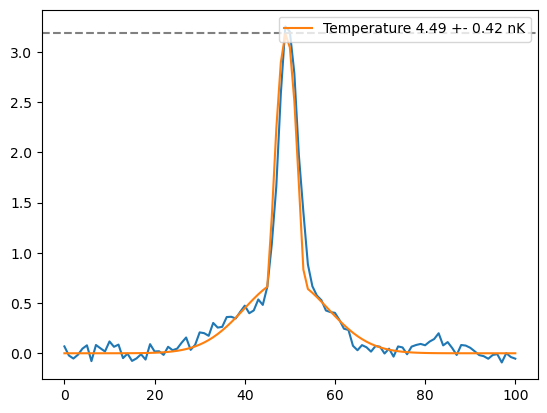

Temperature 4.49 +- 0.42 nK
[  0.73292749  49.67023321 175.25341591   2.45696858   4.21636803]



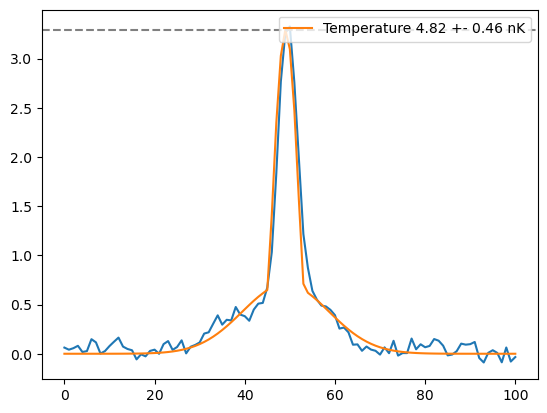

Temperature 4.82 +- 0.46 nK
[  0.70674603  49.56642832 187.86613943   2.58785796   4.13784847]



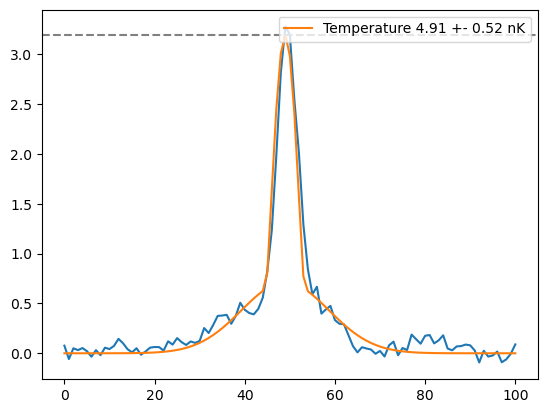

Temperature 4.91 +- 0.52 nK
[  0.71175131  49.45869713 191.43529001   2.48407534   4.36875902]



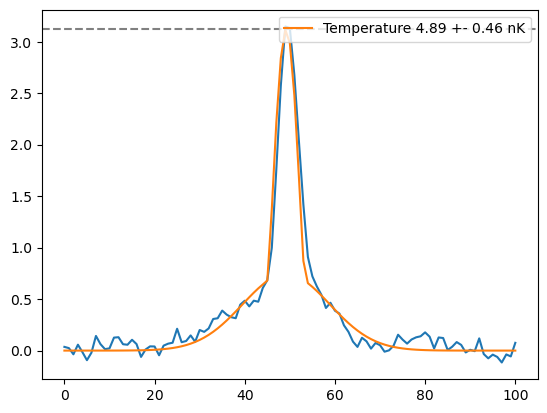

Temperature 4.89 +- 0.46 nK
[  0.74116255  49.67574032 190.72803293   2.38015412   4.26200057]



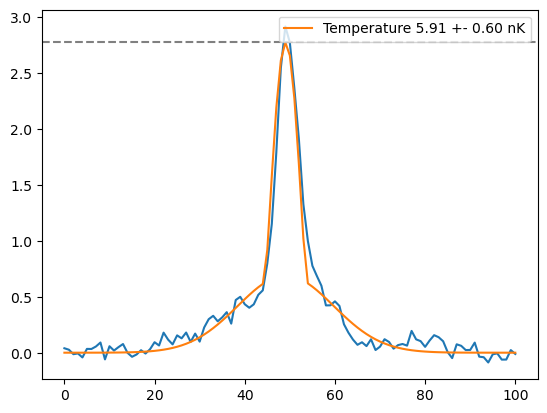

Temperature 5.91 +- 0.60 nK
[  0.6897196   49.57211837 230.64266118   2.08791975   4.7959215 ]



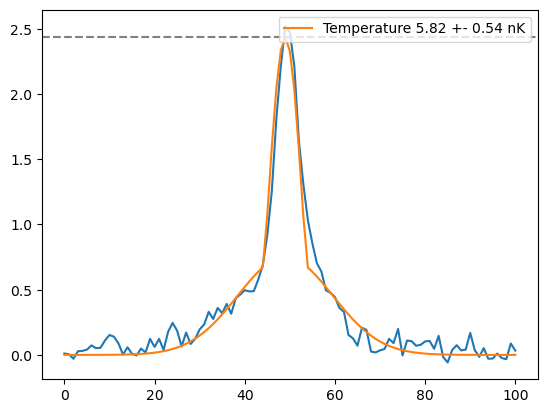

Temperature 5.82 +- 0.54 nK
[  0.74928211  49.47409646 226.93103541   1.6865746    5.06347987]



In [23]:
for i, im in images_fit.iterrows():

    T4 = np.mean(im["density"], axis = 1).compressed()
    pos = np.arange(0, len(T4))

    plt.plot(pos, T4)

    plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), im["T4_params"][0],
                                                              im["T4_params"][1],
                                                              im["T4_params"][2],
                                                              im["T4_params"][3],
                                                              im["T4_params"][4],), label = f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK")

    # plt.axhline(im["T4_params"][0] + im["T4_params"][3], color = "grey", ls = "--")
    plt.axhline(im["T4_peak"], color = "grey", ls = "--")

    plt.legend(loc = 1)

    plt.show()

    # print(f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK @ {im["FB_Img"]:.0f} G")
    print(f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK")
    print(im["T4_params"])
    print("")

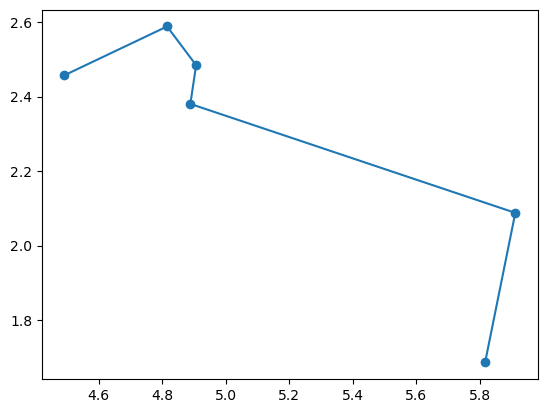

In [24]:
peeeek = []
TTT = []

for i, im in images_fit.iterrows():
    peeeek.append(im["T4_params"][-2])
    TTT.append(im["temperature"][0])

plt.scatter(TTT, peeeek)
plt.plot(TTT, peeeek)

plt.show()


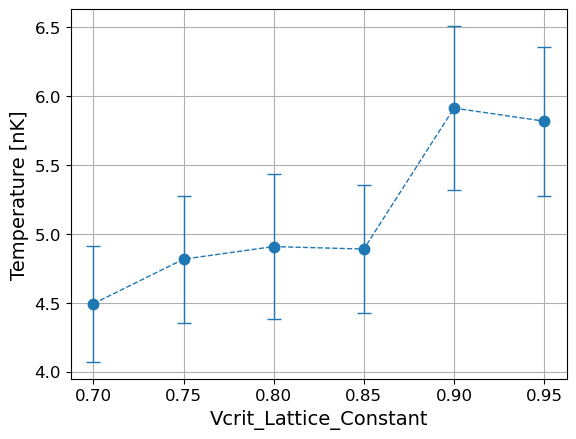

In [26]:
x = np.array(images_fit["Vcrit_Lattice_Constant"].tolist())
y = np.array(images_fit["temperature"].tolist())

plt.errorbar(x, y[:, 0], y[:, 1], marker = ".", ms = 15, lw = 1, ls = "--", elinewidth = 1, capsize = 5)

plt.xlabel(f"{variables[1]}", fontsize = 14)
plt.ylabel("Temperature [nK]", fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid(visible = True, which = "both")

plt.show()